# A/B Testing analysis: evaluating the performance of the new website

## Introduction

This notebook presents the **analysis of an A/B experiment** performed on a web page with the objective of comparing the new user experience (Test group) versus the old one (Control group). The purpose is to **evaluate the impact of the new version** of the website on the conversion rate, time spent on the page and error rate.

The analysis covers the following main areas:

1. **Data cleaning and initial preparation**:
- Cleaning the original dataframes and merging the web interaction data to create a unified dataset.

2. **Creating the final dataframes**:
- Generating a comprehensive dataframe that includes client KPIs, demographic information, and experiment groups.
- Creating a separate dataframe focused on step-by-step interaction metrics for a more detailed step analysis.

3. **Data analytics**:
- Demographic Analysis: Understanding the main client segments and identifying key characteristics of the customer base.
- A/B Testing Analysis: Comparing the performance of the control and test groups to assess the impact of the new design.
- KPI Analysis by Demographics: Exploring how demographic features influence key performance indicators.
- Steps Analysis: Identifying patterns in step-by-step behavior and evaluating friction points or areas of confusion.

4. **Hypothesis testing**:

- Statistical evaluation of the significant differences between the control and test groups for various KPIs and user behavior metrics.

5. **Conclusions and recommendations**:

- Summarizing key insights from the analysis and suggesting actionable recommendations based on the findings to improve user experience and conversion rates.

## Data loading

In this section, we **load the original data** and perform the **necessary transformations** for the analysis. Null values are removed and data types are adjusted to ensure correct manipulation in the following steps.

### 1. Import all the libraries, functions and files necessary for the project

In [82]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway

In [83]:
# Import functions and set autoreload
from functions import *
%reload_ext autoreload
%autoreload 2

In [84]:
# Import data from the different raw files
df_demo = pd.read_csv('data/raw/df_final_demo.txt') # Contains demographic, financial and activity information for each customer.
df_web_data_pt1 = pd.read_csv('data/raw/df_final_web_data_pt_1.txt') # Records the first part of interactions on the web, with: client ID, visitor ID, visit ID, process step and timestamp
df_web_data_pt2 = pd.read_csv('data/raw/df_final_web_data_pt_2.txt') # Records the second part of interactions on the web, with: client ID, visitor ID, visit ID, process step and timestamp
df_experiment_clients = pd.read_csv('data/raw/df_final_experiment_clients.txt') # Contains the assignment of each client to the control group or to the test group in the A/B experiment.

### 2. Join the web data

In [85]:
df_web_data = pd.concat([df_web_data_pt1, df_web_data_pt2], ignore_index=True)

## Cleaning and initial preparation

### 1. Cleaning dataframes

##### Df_demo

In [86]:
#Call the function that will remove rows with too many null values and duplicate rows
df_demo = remove_nulls_and_duplicates(df_demo, threshold=0.8) 

# Change the names of the columns of this dataframe, to make it simpler and more understandable.
df_demo = rename_columns_1(df_demo)

# Fill the null values by the mean in the age column
df_demo = mean_fill_missing_values(df_demo, 'client_age')

# Convert gender to categorical to facilitate analysis
df_demo = convert_to_categorical(df_demo, 'gender')

# Remove the X category from the gender column
df_demo['gender'] = df_demo['gender'].cat.remove_categories('X')

c:\Users\almuo\Desktop\IRONHACK\PROJECT 2 AB TESTING\Vanguard-AB-Test-Analysis\functions.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop_duplicates(inplace=True)


##### Df_web_data

In [87]:
# Convert the date_time column to a datetime format
df_web_data = convert_to_datetime(df_web_data, 'date_time')

# Convert the steps into numbers (0, 1, 2, 3, 4) to be able to work with them more easily.
convert_steps_to_number(df_web_data, 'process_step')

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,3,2017-04-17 15:18:04
...,...,...,...,...,...
755400,9668240,388766751_9038881013,922267647_3096648104_968866,0,2017-05-24 18:46:10
755401,9668240,388766751_9038881013,922267647_3096648104_968866,0,2017-05-24 18:45:29
755402,9668240,388766751_9038881013,922267647_3096648104_968866,1,2017-05-24 18:44:51
755403,9668240,388766751_9038881013,922267647_3096648104_968866,0,2017-05-24 18:44:34


##### Df_experiment_clients

In [88]:
# Change the name of the column 'Variation' to 'experiment_group' to avoid the use of capital letters and make it more understandable.
df_experiment_clients.rename(columns={'Variation': 'experiment_group'}, inplace=True) 

# Convert the experiment group column to a categorical data type to facilitate analysis.
df_experiment_clients = convert_to_categorical(df_experiment_clients, 'experiment_group')

### 2. Condensing web data

We extract information from the df_web_data to **create a dataframe** in which each customer has a single row. The original dataframe has many records per client, for each interaction on the web site, totaling 755405 rows. We **condens the information** to reduce the amount of redundant data. 

The result is a more manageable dataframe, where **each row represents a unique customer with its key metrics**. This structure will facilitate efficient merge with other dataframes and subsequent analysis, which are essential for our A/B testing analysis.

##### Number of visits

How many unique visits (visit_id) each customer made in the online process.

In [89]:
# Count how many unique visits (visit_id) each customer made in the online process
visits_count = df_web_data.groupby('client_id')['visit_id'].nunique().reset_index()
visits_count.columns = ['client_id', 'num_visits']

##### Number of steps

Total number of unique steps (process_step) that each customer completed in all visits.

In [90]:
# Count the total number of unique steps (process_step) that each customer completed in all visits
steps_count = df_web_data.groupby('client_id').size().reset_index(name='num_steps')

##### Completion status

Boolean indicator that marks whether the customer reached the final step (confirm) or not.

In [91]:
# Calculate completion rate: a Boolean indicator that marks whether the customer reached the final step (confirm) or not.
df_web_data['completed'] = df_web_data['process_step'] == 4
completion_rate = df_web_data.groupby('client_id')['completed'].max().reset_index()
completion_rate.columns = ['client_id', 'completion_status']

##### Total time spent

Total time each customer spent in the online process

In [92]:
#Order the dataframe to calculate the difference in time
df_web_data = df_web_data.sort_values(by=['visitor_id', 'date_time'])

# Calculate time spent creating a column in the original dataframe
df_web_data['time_spent'] = df_web_data.groupby('visit_id')['date_time'].diff().shift(-1)

# Calculate total time spent per client
total_time_per_client = df_web_data.groupby('client_id')['time_spent'].sum().reset_index()
total_time_per_client.columns = ['client_id', 'total_time_spent']

##### Repeated step

Boolean indicator that signals if the client repeated any step in the process

In [93]:
# Extract a boolean indicator that signals if the client repeated any step in the process

# Group by client_id and visit_id to count repeated steps per visit
repeat_steps = df_web_data.groupby(['client_id', 'visit_id'])['process_step'].value_counts()

# Create a dataframe with the count of repeated steps and add a column on whether or not there are repeated steps (appears more than once).
repeat_steps = repeat_steps.reset_index(name='count')
repeat_steps['repeated_step'] = repeat_steps['count'] > 1

# Group this information first by visit_id to see if you have repeated any steps in that visit.
repeat_steps_visit = repeat_steps.groupby(['client_id', 'visit_id'])['repeated_step'].any().reset_index()

# Finally group by client_id, to see if the clients have repeated steps in any of their visits.
repeat_steps_client = repeat_steps_visit.groupby('client_id')['repeated_step'].any().reset_index()

##### Went back

Boolean indicator that signals if the client went back in the process

In [94]:
# Order the dataframe
df_web_data = df_web_data.sort_values(by=['client_id', 'visit_id', 'date_time'])

# Create a column that captures the above step for each customer at each visit.
df_web_data['previous_step'] = df_web_data.groupby(['client_id', 'visit_id'])['process_step'].shift(1)

# Create a column that indicates whether the customer goes backwards in the flow (if the current step is smaller than the previous step).
df_web_data['went_back'] = df_web_data['process_step'] < df_web_data['previous_step']

# Group by client_id and visit_id to see if there were stepbacks on each visit)
error_rate_visits = df_web_data.groupby(['client_id', 'visit_id'])['went_back'].any().reset_index()

# Group by client_id to see if the client had errors on at least one of his visits 
error_rate_client = error_rate_visits.groupby('client_id')['went_back'].any().reset_index()

##### **Create the web dataframe**

In [95]:
df_web = visits_count.copy()

df_web = df_web.merge(steps_count, on='client_id', how='left')
df_web = df_web.merge(completion_rate, on='client_id', how='left')
df_web = df_web.merge(total_time_per_client, on='client_id', how='left')
df_web = df_web.merge(repeat_steps_client, on='client_id', how='left')
df_web = df_web.merge(error_rate_client, on='client_id', how='left')

##### Steps per visit

In [96]:
#Complete the information with an average of steps per visit
df_web['steps_per_visit'] = (df_web['num_steps']/df_web['num_visits']).round(2)

##### Total time in seconds

In [97]:
#Complete the information with a column of the time expressed in seconds
df_web['total_time_seconds'] = df_web['total_time_spent'].dt.total_seconds().astype(int)

##### Time per step

In [98]:
#Calculate the average time per step
df_web['time_per_step'] = df_web['total_time_seconds'] / df_web['num_steps']

## Create the final dataframes

**df_complete**

This dataframe groupss demographic, web interaction, and experiment group data for each client. It is used for overall analysis, combining key performance indicators (KPIs) with client information.

- **client_id**: Unique identifier for each client.
- **client_tenure_years**: Number of years the client has been with the company.
- **client_tenure_months**: Further breakdown of the client’s tenure in months.
- **client_age**: Age of the client.
- **gender**: Gender of the client (M, F, or U for unknown).
- **num_accounts**: Total number of accounts the client holds.
- **balance**: Total balance in all client accounts.
- **calls_last_6_months**: Number of calls made by the client in the last 6 months.
- **logons_last_6_months**: Number of times the client logged into the platform over the last 6 months.
- **experiment_group**: Indicates whether the client was in the Test or Control group for the experiment.
- **num_visits**: Number of visits made by the client during the experiment period.
- **num_steps**: Total number of steps completed by the client during their interaction.
- **steps_per_visit**: Average number of steps taken per visit.
- **total_time_spent**: Total time spent by the client in the process (in a timedelta format).
- **total_time_seconds**: Total time spent by the client in seconds.
- **time_per_step**: Average time spent per step.
- **completion_status**: Indicates if the client completed the process (True or False).
- **repeated_step**: Indicates if the client repeated any steps (True or False).
- **went_back**: Indicates if the client went back during the process (True or False).

This dataframe is used to evaluate overall client behavior, group comparisons, and KPI performance for the A/B testing analysis.


**steps_df**

This dataframe focuses on step-specific metrics to identify problem areas, friction points, and differences between the Control and Test groups in each step of the web interaction.

- **experiment_group**: Indicates the experiment group (Control or Test).
- **process_step**: Step number in the interaction process (e.g., 0 for the starting point, 4 for confirmation).
- **mean_time_spent**: Average time (in seconds) spent by users in that specific step.
- **std_time_spent**: Standard deviation of the time spent on the step, indicating variability.
- **friction_rate**: Proportion of users moving backwards from that step.
- **times_repeated**: Average number of times this step was repeated by users.

This dataframe provides a detailed view of step-by-step performance to identify potential UX issues, step-specific friction, and to make targeted recommendations for improving the client experience.

### **1. Create df_complete**

Join df_demo, df_web and df_experiment_clients

In [99]:
df_complete = df_demo.merge(df_experiment_clients, on='client_id', how='left')
df_complete = df_complete.merge(df_web, on='client_id', how='left')

We fill in null values to avoid errors, as we do not know which group of experiment they are from, we leave them as 'Unknown'.

In [100]:
# Add 'Unknown' as a category for experiment group
df_complete['experiment_group'] = df_complete['experiment_group'].cat.add_categories('Unknown')

# Fill the missing values with 'Unknown'
df_complete['experiment_group'].fillna('Unknown', inplace=True)

C:\Users\almuo\AppData\Local\Temp\ipykernel_2544\2065902673.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_complete['experiment_group'].fillna('Unknown', inplace=True)


### 2. Manage outliers and adapt data

##### Remove Unknown experiment group

As the analysis is about A/B testing, we are going to remove the information of the customers in this dataframe for which it is not specified to which group of the experiment they belong.

In [101]:
# Filter out 'Unknown' from the dataframe
df_filtered = df_complete[df_complete['experiment_group'] != 'Unknown']

# Remove the specific category 'Unknown'
df_filtered['experiment_group'] = df_filtered['experiment_group'].cat.remove_categories('Unknown')

C:\Users\almuo\AppData\Local\Temp\ipykernel_2544\3308181009.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['experiment_group'] = df_filtered['experiment_group'].cat.remove_categories('Unknown')


##### Create categorical age

In [102]:
# Define age ranges and labels
bins = [12, 34, 49, 64, 101] 
labels = ['13-34', '35-49', '50-64', '65-100']

# Create a new column 'categorical_age' with the age categories
df_filtered['categorical_age'] = pd.cut(df_filtered['client_age'], bins=bins, labels=labels, right=False)

C:\Users\almuo\AppData\Local\Temp\ipykernel_2544\2594341382.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['categorical_age'] = pd.cut(df_filtered['client_age'], bins=bins, labels=labels, right=False)


##### Create categorical balance

In [103]:
# Define age ranges and labels
bins=[-float('inf'), 39586.055, 64548.38, 133473.475, float('inf')]
labels=['Low', 'Medium', 'High', 'Very High']

df_filtered['balance_category'] = pd.cut(df_filtered['balance'], bins=bins, labels=labels)

C:\Users\almuo\AppData\Local\Temp\ipykernel_2544\93426040.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['balance_category'] = pd.cut(df_filtered['balance'], bins=bins, labels=labels)


##### Remove outliers

After observing the variables in a boxplot, we eliminate the most extreme values, but without trying to lose too much information.

In [104]:
df_filtered = df_filtered[df_filtered['client_tenure_months'] <= 700]
df_filtered = df_filtered[df_filtered['steps_per_visit'] <= 30]
df_filtered = df_filtered[df_filtered['total_time_seconds'] <= 4000]
df_filtered = df_filtered[df_filtered['balance'] <= 1000000]
df_filtered = df_filtered[df_filtered['num_visits'] <= 15]
df_filtered = df_filtered[df_filtered['num_steps'] <= 60]

### 3. Create some filtered dataframes

In [105]:
df_test = df_filtered[df_filtered['experiment_group'] == 'Test'] # To have a dataframe only of those who are in the Test group
df_control = df_filtered[df_filtered['experiment_group'] == 'Control'] # To have a dataframe only of those who are in the Control group
df_completed = df_filtered[df_filtered['completion_status'] == True] # To have a dataframe only of those who have completed the process

### **4. Create the steps dataframe**

##### Time spent per step

In [25]:
df_web_data['time_spent'] = pd.to_timedelta(df_web_data['time_spent'], errors='coerce')
df_web_data['time_spent'].fillna(pd.Timedelta(seconds=0), inplace=True)
df_web_data['time_spent_seconds'] = df_web_data['time_spent'].dt.total_seconds().astype(int)

C:\Users\almuo\AppData\Local\Temp\ipykernel_2544\937711819.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_web_data['time_spent'].fillna(pd.Timedelta(seconds=0), inplace=True)


##### Add experiment groups

In [26]:
df_web_data = pd.merge(df_web_data, df_experiment_clients, on='client_id', how='left')
df_web_data.dropna(inplace=True)

##### **Create the dataframe**: 'experiment_group', 'process_step', 'mean_time_spent' and 'std_time_spent'

In [27]:
#Extract the necessary info from df_web_data
steps_df = df_web_data.groupby(['experiment_group', 'process_step']).agg({'time_spent_seconds': ['mean', 'std']}).reset_index()

# Rename columns for clarity
steps_df.columns = ['experiment_group', 'process_step', 'mean_time_spent', 'std_time_spent']

C:\Users\almuo\AppData\Local\Temp\ipykernel_2544\3504013289.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  steps_df = df_web_data.groupby(['experiment_group', 'process_step']).agg({'time_spent_seconds': ['mean', 'std']}).reset_index()


##### Error rate per step

It is different from the 'went_back' calculation because we are not interested in the step they go back to, but we want to take out the step that makes them go back.

In [28]:
# Crear la columna 'friction_in_step' que marca el paso problemático (donde ocurre la fricción)
df_web_data['friction_step'] = (df_web_data['process_step'] < df_web_data['previous_step'])

#Cambiar la columna 'went_back' para indicar el paso problemático anterior (la fricción)
df_web_data['friction'] = df_web_data['friction_step'].shift(-1)

friction_rate = (df_web_data.groupby(['experiment_group', 'process_step'])['friction'].mean().reset_index(name='mean_went_back_rate'))

steps_df['friction_rate'] = friction_rate['mean_went_back_rate']

C:\Users\almuo\AppData\Local\Temp\ipykernel_2544\3910624506.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  friction_rate = (df_web_data.groupby(['experiment_group', 'process_step'])['friction'].mean().reset_index(name='mean_went_back_rate'))


##### Times repeated

In [29]:
# Group by client_id and visit_id to count repeated steps per visit
repeat_steps = df_web_data.groupby(['client_id', 'visit_id'])['process_step'].value_counts()
repeat_steps = repeat_steps.reset_index(name='count')

#Combine with the df_experiment_clients to obtain the experiment group
repeat_steps = repeat_steps.merge(df_experiment_clients, on='client_id', how='left')

# Create a column with the average times repeated for each steps
steps_df['times_repeated'] = repeat_steps.groupby(['process_step', 'experiment_group'])['count'].transform('mean')

C:\Users\almuo\AppData\Local\Temp\ipykernel_2544\2186784248.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  steps_df['times_repeated'] = repeat_steps.groupby(['process_step', 'experiment_group'])['count'].transform('mean')


## Data Analytics

The goal of the data analytics process is to derive insights from our exploratory analysis, using relevant KPIs to compare and contrast the **Test and Control groups**, and to assess the impact of demographic variables. The analysis focuses on four key areas:

**1. Demo analysis**: Investigating the distribution of key demographic variables like tenure, age, gender, and balance to understand the nature of our client base.

**2. A/B testing analysis**: Comparing key performance metrics between the Test and Control groups, including completion rate, error rate, and repetition rate, to evaluate the effectiveness of the new web design.

**3. KPIs related to demographics**: Examining the relationships between demographic variables (age, balance, etc.) and key metrics such as completion rate, error rate, and time spent. This helps identify which groups are more affected by the new design.

**4. Step-by-step process analysis**: Analyzing each process step to identify potential sticking points or areas of friction in the Test group, comparing it to the Control group for detailed insights.

### 1. Demo analysis

- **Tenure**: the database shows a **well-established clientele** with an average age of 12 years and a maximum of 62 years, reflecting **good long-term retention**. The distribution is slightly skewed to the right and concentrated in low values (75% of clients are less than 26 years old), with some exceptional clients exceeding 30 years.

- **Gender**: percentages of men (33%), women (32%) and undefined (34%) are very similar, suggesting that the demographic data is incomplete in this aspect. With the information we have, **no gender seems to stand out** among the clients.

- **Age**: the database is skewed toward **middle-aged and older clients** (mean 46.4 years) with an almost symmetrical distribution and no outliers. Although age varies quite a bit (range = 82.5), the majority is concentrated between **35 and 60**, indicating a relatively diverse but balanced clientele.

- **Number of accounts**: vast majority of clients (78.61%) have **2 accounts**, which also coincides with the median and mode. There is **little variation** in the number of accounts (std = 0.53), but the distribution is skewed to the right, as a few clients have many more accounts. All this generate a pronounced peak around 2 accounts (Kurtosis = 6.09).

- **Balance**: the mean (147.450) is much higher than the median (63.336), reflecting a **highly right-skewed distribution** with a long tail toward high values. The standard deviation (301.514) and range (over 16 million) are extremely high, indicating large dispersion. The Kurtosis (278.2) reveals a **pronounced peak** with few extreme values, although most clients have lower balances, up to 500,000.

- **Logons last 6 months**: the mode is 9, a high number of logins and **17.49% of clients show a high level of activity**. On average, clients log in 5 times in this period. Although the range is wide (1 to 9 logins), there are **few clients with low activity** (8.42% with only 1 or 2 logins). The distribution is symmetric and relatively flat, as reflected by the negative Kurtosis (-1.06) and a skewness close to 0, indicating balance in the number of clients per activity level.

In [30]:
df_demo.describe().round(2)

,client_id,client_tenure_years,client_tenure_months,client_age,num_accounts,balance,calls_last_6_months,logons_last_6_months
count,70595.00,70595.00,70595.00,70595.00,70595.00,70595.00,70595.00,70595.00
mean,5005020.95,12.05,150.66,46.44,2.26,147445.24,3.38,5.57
std,2877269.22,6.87,82.09,15.59,0.53,301508.71,2.24,2.35
min,169.00,2.00,33.00,13.50,1.00,13789.42,0.00,1.00
25%,2519604.50,6.00,82.00,32.50,2.00,37346.84,1.00,4.00
50%,5016969.00,11.00,136.00,47.00,2.00,63332.90,3.00,5.00
75%,7483063.50,16.00,192.00,59.00,2.00,137544.90,6.00,7.00
max,9999839.00,62.00,749.00,96.00,8.00,16320040.15,7.00,9.00


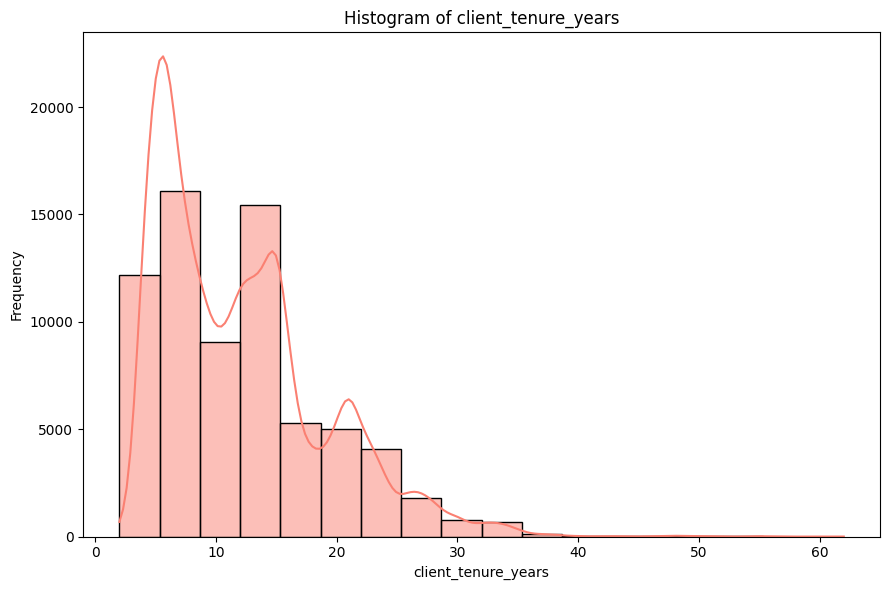

In [31]:
plot_histogram(df_demo, 'client_tenure_years', bins=18)

c:\Users\almuo\Desktop\IRONHACK\PROJECT 2 AB TESTING\Vanguard-AB-Test-Analysis\functions.py:271: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, palette="pastel")


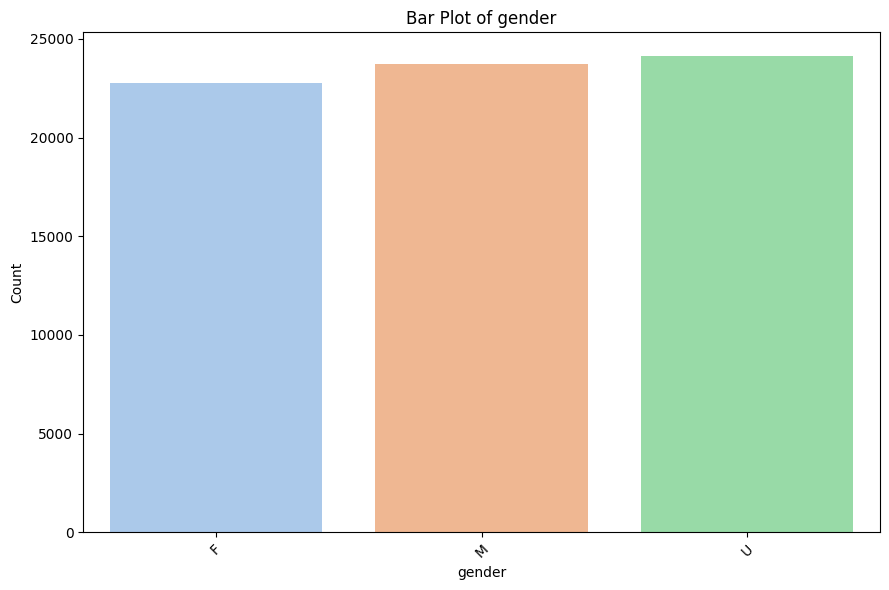

In [32]:
plot_barplot(df_demo, 'gender')

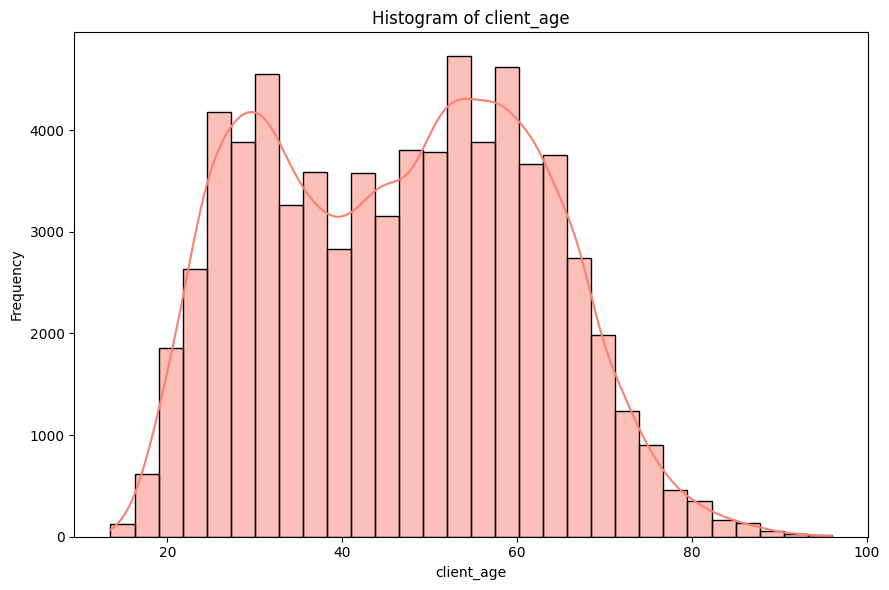

In [33]:
plot_histogram(df_demo, 'client_age', bins=30)

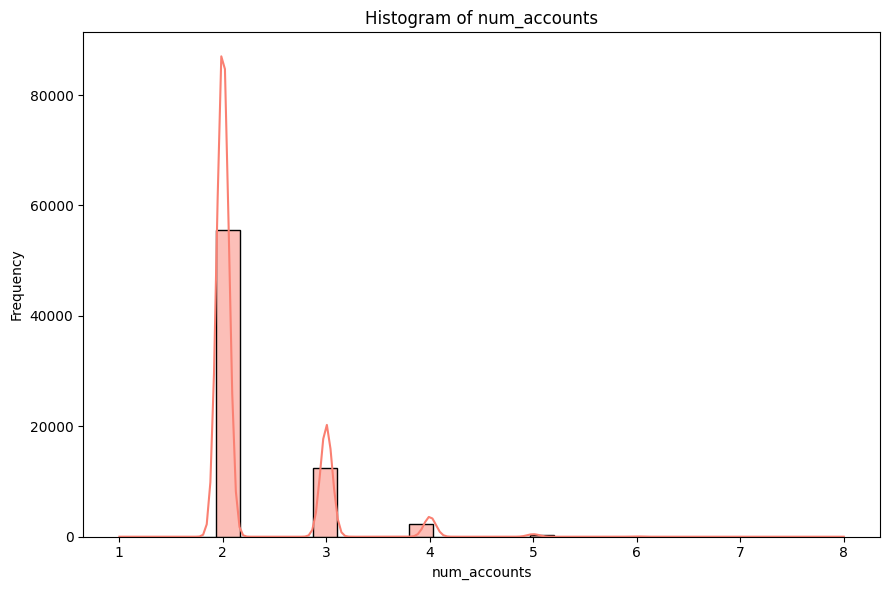

In [34]:
plot_histogram(df_demo, 'num_accounts', bins=30)

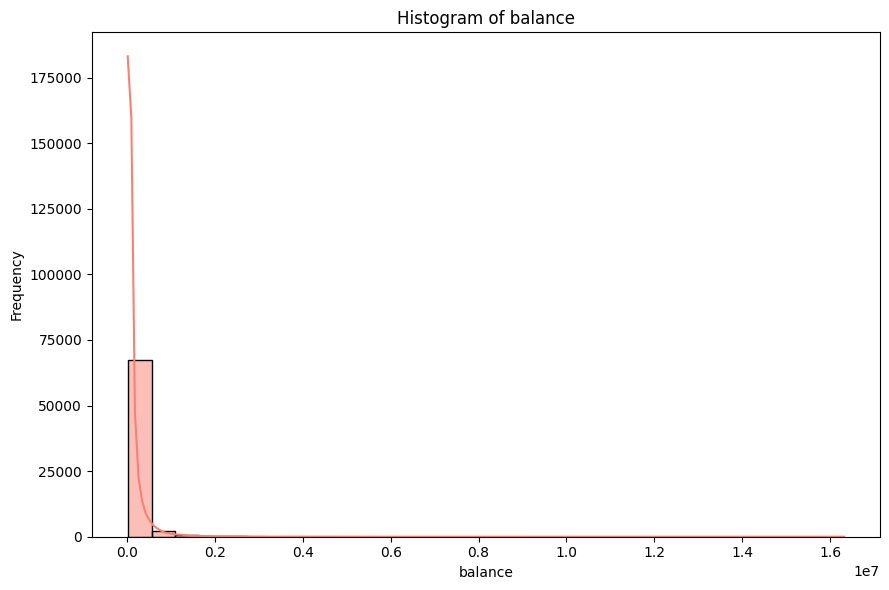

In [35]:
plot_histogram(df_demo, 'balance', bins=30)

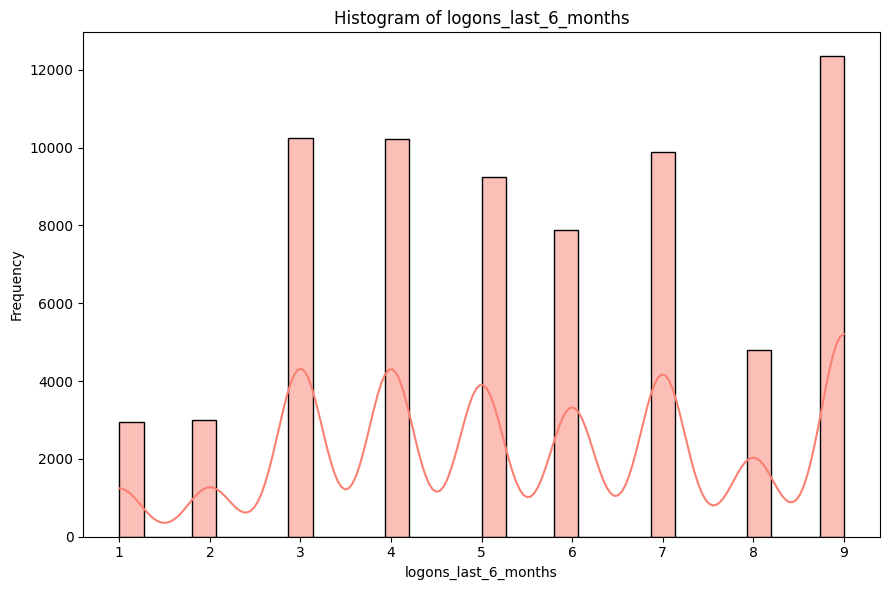

In [36]:
plot_histogram(df_demo, 'logons_last_6_months', bins=30)

##### **Age and balance**

There's a moderate positive relationship between the age and the balance of the clients.

In [65]:
correlation_age_balance = df_filtered['client_age'].corr(df_filtered['balance'], method='spearman')
correlation_age_balance

np.float64(0.3222843495355278)

### 2. A/B testing analysis

##### **Completion rate**

The **Test Group** has a slightly higher completion rate (69.19%) compared to the Control Group (65.44%). 

- **Chi-square Test**: The difference is statistically significant ( p < 0.05).
- **Cramér's V**: The strength of the relationship is weak (Cramér's V = 0.04), suggesting that while the new design may slightly improve completion rates, the effect size is not substantial.

This suggests that other variables should be analyzed to better understand the overall impact of the new design.

Text(0.5, 1.0, 'Conversion rate by experiment group')

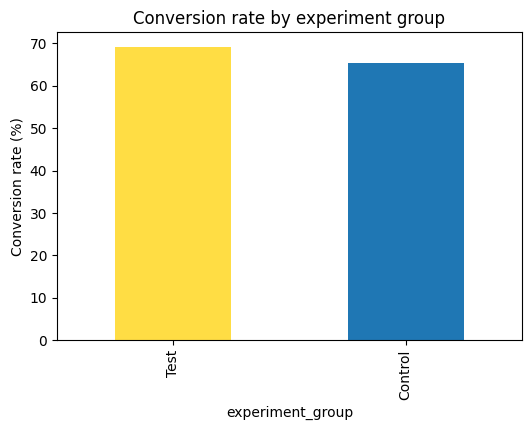

In [43]:
# Calculate the conversion rate (percentage of 'True' values) for each group
conversion_rate = df_filtered[df_filtered['completion_status'] == True]['experiment_group'].value_counts() / df_filtered['experiment_group'].value_counts() * 100

# Plot the results
conversion_rate.plot(kind='bar', color=['#ffdd44', '#1f77b4'], figsize=(6, 4))
plt.ylabel('Conversion rate (%)')
plt.title('Conversion rate by experiment group')

In [38]:
crosstab_completion = pd.crosstab(df_filtered['experiment_group'], df_filtered['completion_status'])

# Chi-square test for significance
print(chi_results(crosstab_completion))

# Computing the association between experiment group and completion rate
print(cramer_result(crosstab_completion))

8.43593602628941e-19
0.039889085157142415


##### **Error rate**

**Test group shows a significantly higher error rate** (almost 0 p-value), or proportion of user who go back in the process, compared to the Control Group. It may indicate friction or confusion in the new design.

Even though the **effect size is weak** (0,078 Cramer's), this difference is notable.

Text(0.5, 1.0, 'Error rate by experiment group')

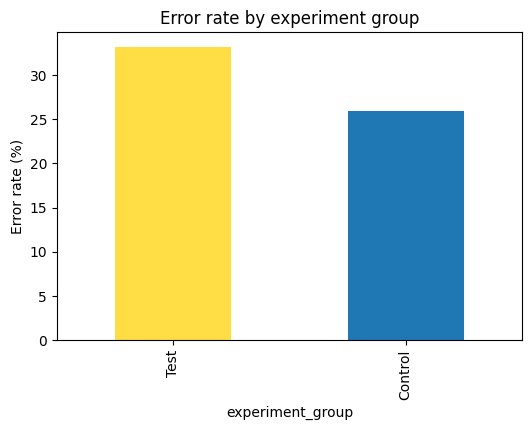

In [59]:
# Calculate the error rate (percentage of 'True' values in 'went_back') for each group
error_rate = df_filtered[df_filtered['went_back'] == True]['experiment_group'].value_counts() / df_filtered['experiment_group'].value_counts() * 100

# Plot the results
error_rate.plot(kind='bar', color=['#ffdd44', '#1f77b4'], figsize=(6, 4))
plt.ylabel('Error rate (%)')
plt.title('Error rate by experiment group')

In [39]:
crosstab_error = pd.crosstab(df_filtered['experiment_group'], df_filtered['went_back'])


# Chi-square test for significance
print(chi_results(crosstab_error))

# Computing the association between experiment group and error rate
print(cramer_result(crosstab_error))

8.242814894086898e-69
0.07894050395466942


##### **Repetition rate**

**Test group shows a higher repetition rate** compared to the Control group. This statistical significance is strong (almost zero P-Value), but the magnitude of the effect is small (0,067).

It may indicate that the new website is confusing or has some flaw in the process ideation that leads to repetition of steps, but still **the impact is low**.

Text(0.5, 1.0, 'Repetition rate by experiment group')

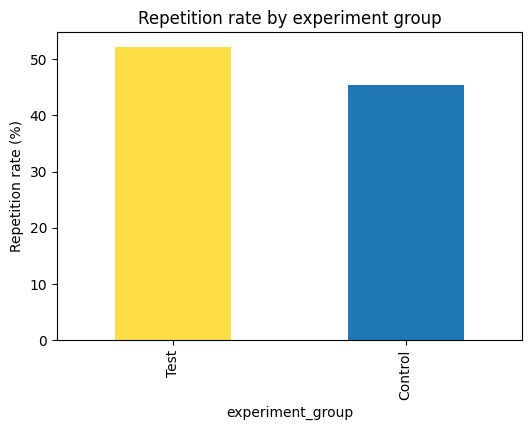

In [40]:
# Calculate the repetition rate (percentage of users that repeated a step) for each group
repeat_rate = df_filtered[df_filtered['repeated_step'] == True]['experiment_group'].value_counts() / df_filtered['experiment_group'].value_counts() * 100

# Plot the results
repeat_rate.plot(kind='bar', color=['#ffdd44', '#1f77b4'], figsize=(6, 4))
plt.ylabel('Repetition rate (%)')
plt.title('Repetition rate by experiment group')

In [41]:
crosstab_repeat= pd.crosstab(df_filtered['experiment_group'], df_filtered['repeated_step'])


# Chi-square test for significance
print(chi_results(crosstab_repeat))

# Computing the association between experiment group and repetition rate
print(cramer_result(crosstab_repeat))

6.673142088802657e-50
0.06688203128243198


##### Time per step

The differences in time spent per step between the two groups are minimal and not significant, indicating that the new design does not affect (in general) on the time required to complete each step.

C:\Users\almuo\AppData\Local\Temp\ipykernel_2544\2827934871.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_filtered, x='experiment_group', y='time_per_step', palette=color_dict)


Text(0, 0.5, 'Average time per step (seconds)')

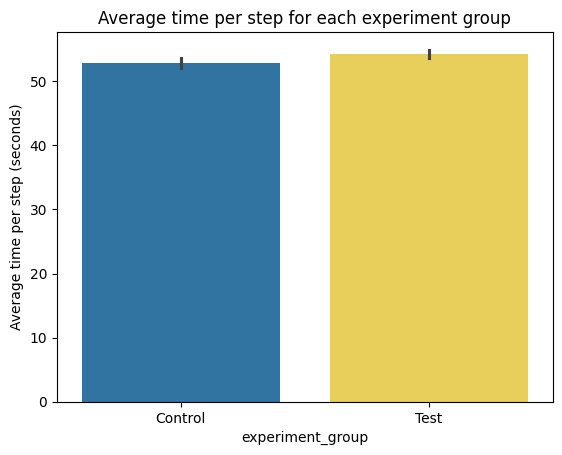

In [50]:
# Plotting a bar plot to visualize the average time per step for each experiment group
color_dict = {'Control': '#1f77b4', 'Test': '#ffdd44'}
sns.barplot(data=df_filtered, x='experiment_group', y='time_per_step', palette=color_dict)
plt.title('Average time per step for each experiment group')
plt.ylabel('Average time per step (seconds)')

### 3. KPIs related to demo

##### **Age vs completion rate**

Age has a significant effect on completion rate, but the strength of association is low (0.07), other variables influence more the results.

The **completion rate decreases with increasing age** in both groups (Control and Test). But the new web version shows a slight improvement in almost all age groups. The improvement in **young people stands out**, while in older clients (65-100 years old) the results are the same or even slightly worse.

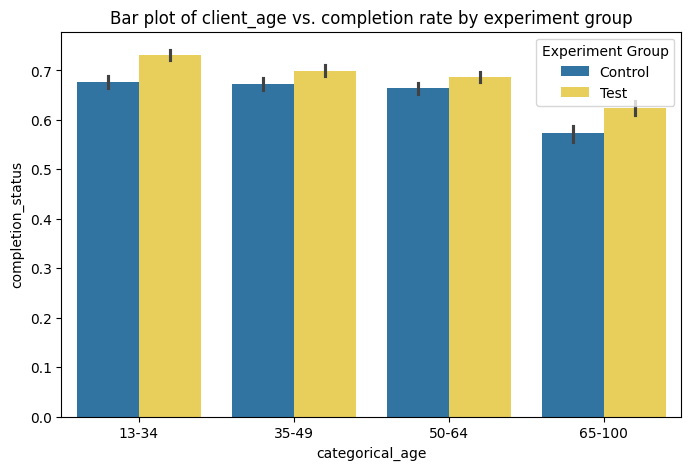

In [ ]:
plt.figure(figsize=(8, 5)) 
plt.title('Bar plot of client_age vs. completion rate by experiment group')
# Combined bar chart with the use of 'hue' to compare Test and Control
sns.barplot(data=df_filtered, y='completion_status', x='categorical_age', hue='experiment_group', palette=color_dict)
plt.legend(title='Experiment Group')

In [ ]:
crosstab_completion_age = pd.crosstab(df_filtered['categorical_age'], df_filtered['completion_status'])

# Chi-square test for significance
print(chi_results(crosstab_completion_age))

# Computing the association between age group and completion rate
print(cramer_result(crosstab_completion_age))

5.250632143417159e-58
0.07380062882766858


##### **Age vs. Error rate**

There is a significant difference in the “went back” rate by age. The association is weak, with 0.077 Cramer's V for the Control group and 0.073 for the Test.

The **new version shows higher error rates in older users** (50-100 years), in younger users the differences are minimal.

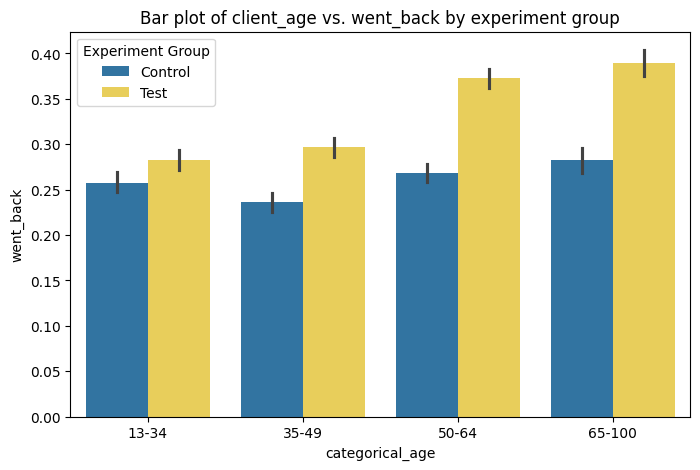

In [49]:
plt.figure(figsize=(8, 5)) 
plt.title('Bar plot of client_age vs. went_back by experiment group')
# Combined bar chart with the use of 'hue' to compare Test and Control
sns.barplot(data=df_filtered, y='went_back', x='categorical_age', hue='experiment_group', palette=color_dict)
plt.legend(title='Experiment Group')

In [55]:
crosstab_error_age_c = pd.crosstab(df_control['categorical_age'], df_control['completion_status'])

# Chi-square test for significance in Control Group
print(chi_results(crosstab_error_age_c))

# Computing the association in Control Group
print(cramer_result(crosstab_error_age_c))

2.2806262858531816e-29
0.0769349588917249


In [56]:
crosstab_error_age_t = pd.crosstab(df_test['categorical_age'], df_test['completion_status'])

# Chi-square test for significance in Test Group
print(chi_results(crosstab_error_age_t))

# Computing the association in Test Group
print(cramer_result(crosstab_error_age_t))

3.52243975442064e-30
0.07294730263968818


##### **Age vs. Repetition rate**

0lder age categories tend to repeat more steps in the test group. Cramér's V analysis confirms a stronger association in the Test group between age and repeated steps (0.113).

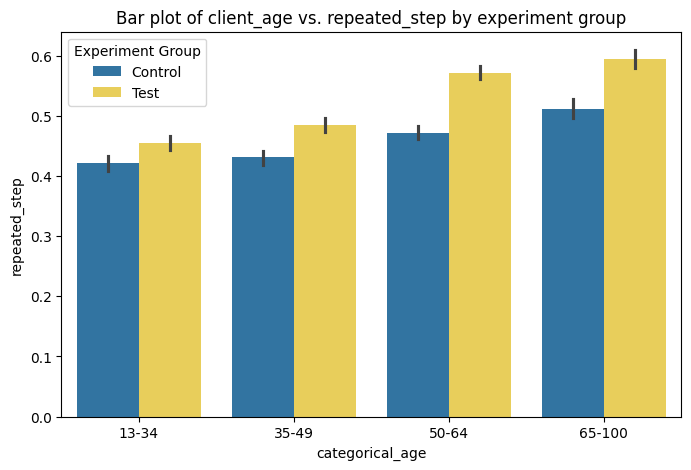

In [57]:
plt.figure(figsize=(8, 5)) 
plt.title('Bar plot of client_age vs. repeated_step by experiment group')
# Combined bar chart with the use of 'hue' to compare Test and Control
sns.barplot(data=df_filtered, y='repeated_step', x='categorical_age', hue='experiment_group', palette=color_dict)
plt.legend(title='Experiment Group')

In [58]:
crosstab_repeat_age = pd.crosstab(df_test['categorical_age'], df_test['repeated_step'])

# Chi-square test for significance
print(chi_results(crosstab_repeat_age))

# Computing the association 
print(cramer_result(crosstab_repeat_age))

8.11166731776101e-72
0.11240417669693822


##### **Age vs. Time spent**

The positive correlation (Spearman: 0.2118) suggests that **as age increases, navigation time also increases**, which could indicate additional challenges with the new interface for older users.

In [59]:
correlation_time = df_test['client_age'].corr(df_test['time_per_step'], method='spearman')
correlation_time

np.float64(0.19555551551731298)

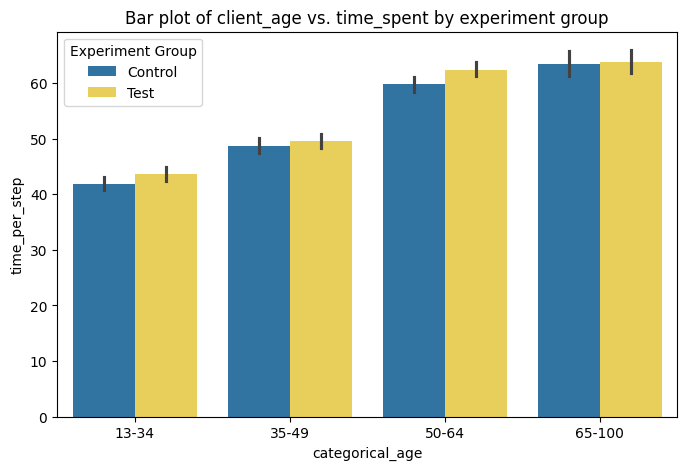

In [60]:
plt.figure(figsize=(8, 5)) 
plt.title('Bar plot of client_age vs. time_spent by experiment group')
# Combined bar chart with the use of 'hue' to compare Test and Control
sns.barplot(data=df_filtered, y='time_per_step', x='categorical_age', hue='experiment_group', palette=color_dict)
plt.legend(title='Experiment Group')

##### Balance vs. completion rate

**There's no significant dependence between these variables**.

In [61]:
crosstab_balance_completion = pd.crosstab(df_test['balance_category'], df_test['completion_status'])

# Chi-square test for significance
print(chi_results(crosstab_balance_completion))

# Computing the association between balance category and completion rate
print(cramer_result(crosstab_balance_completion))

0.23934017349265282
0.012648322226107282


##### Balance vs. Repeat rate

For both versions, there is a tendency for clients with very high balances to repeat more steps during the process.
Customers with higher balances may be spending more time making sure they complete the process correctly.

**But the relationship, is not significant or strong.**

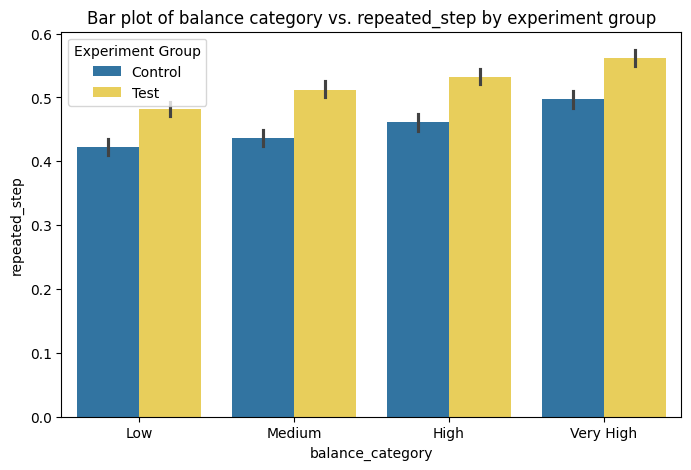

In [64]:
plt.figure(figsize=(8, 5)) 
plt.title('Bar plot of balance category vs. repeated_step by experiment group')
# Combined bar chart with the use of 'hue' to compare Test and Control
sns.barplot(data=df_filtered, y='repeated_step', x='balance_category', hue='experiment_group', palette=color_dict)
plt.legend(title='Experiment Group')

In [63]:
crosstab_balance_repeat = pd.crosstab(df_test['balance_category'], df_test['repeated_step'])

# Chi-square test for significance
print(chi_results(crosstab_balance_completion))

# Computing the association between balance category and repetition rate
print(cramer_result(crosstab_balance_completion))

0.4188559912886969
0.011079370604072549


### 4. Steps analysis

##### **Mean time per step**

**Step 1 and step 3 are sticking points in the new web**. The increased time at the beginning could indicate difficulty in moving forward or additional complexity.

Text(0, 0.5, 'Mean time spent (seconds)')

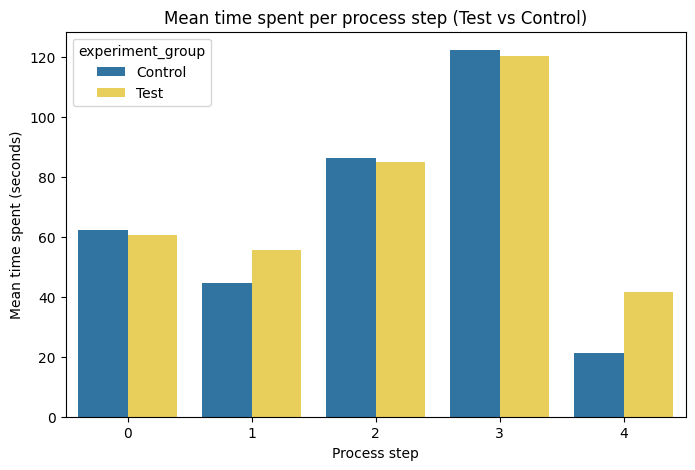

In [66]:
plt.figure(figsize=(8, 5))
sns.barplot(data=steps_df, x='process_step', y='mean_time_spent', hue='experiment_group', palette=color_dict)
plt.title('Mean time spent per process step (Test vs Control)')
plt.xlabel('Process step')
plt.ylabel('Mean time spent (seconds)')

##### **Error rate per step**

The graph clearly shows a sticking point in the first step of the new website, with a higher backlink rate than the old version at this point. Although the third step seems to be more problematic, followed by the second.

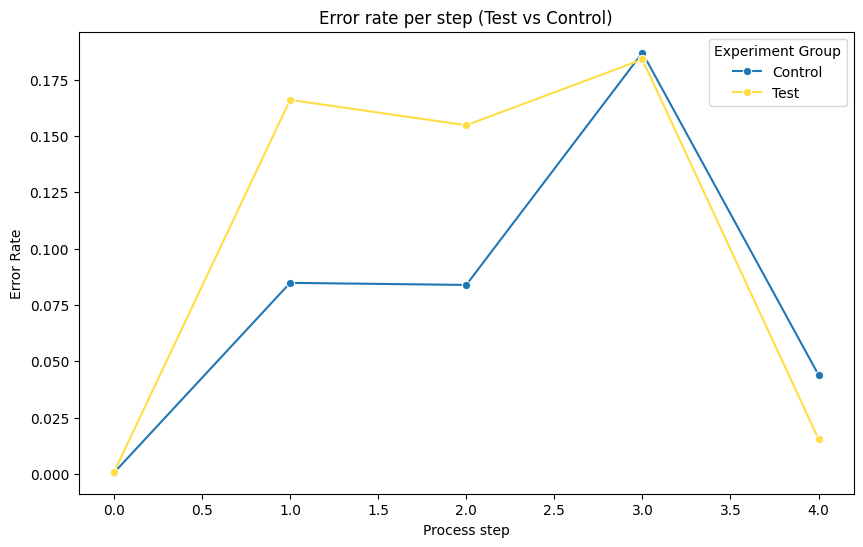

In [67]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=steps_df, x='process_step', y='friction_rate', hue='experiment_group', marker='o', palette=color_dict)
plt.title('Error rate per step (Test vs Control)')
plt.xlabel('Process step')
plt.ylabel('Error Rate')
plt.legend(title='Experiment Group')

##### **Repetition per step**

Show the average number of times each step is repeated. It shows a high number of repetition in the third step for the Test group.

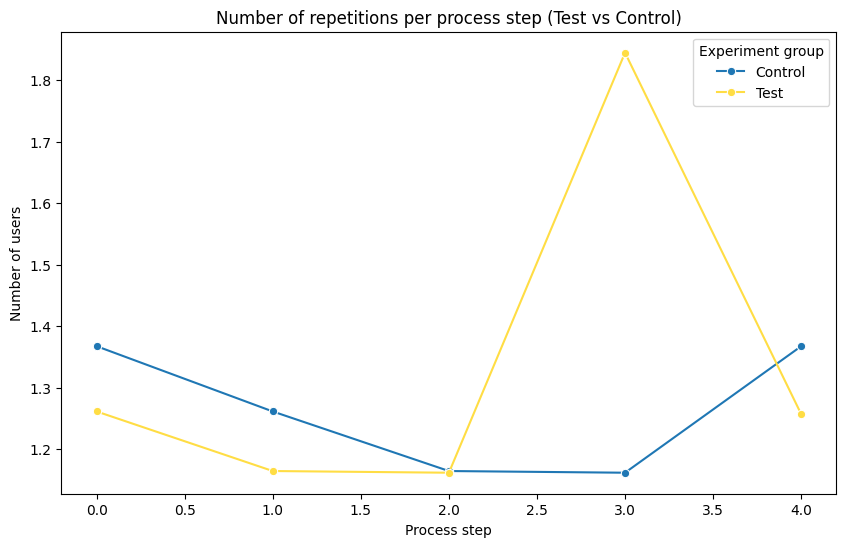

In [68]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=steps_df, x='process_step', y='times_repeated', hue='experiment_group', marker='o', palette=color_dict)
plt.title('Number of repetitions per process step (Test vs Control)')
plt.xlabel('Process step')
plt.ylabel('Number of users')
plt.legend(title='Experiment group')

## Hypothesis testing

### Difference in time per step by experiment group

In [69]:
#Set the hypothesis

# H0: The users spent the same or less time on the new website.
# H1: The users spent more time on the new website.

control_time = df_filtered[df_filtered['experiment_group'] == 'Control']['time_per_step']
test_time = df_filtered[df_filtered['experiment_group'] == 'Test']['time_per_step']

t_stat, p_value = ttest_ind(control_time, test_time)

alpha = 0.05

if p_value > alpha:
    print("We are not able to reject the null hypothesis. The users spent the same or less time on the new website")
else:
    print("We reject the null hypotesis. The users spent more time on the new website")

We reject the null hypotesis. The users spent more time on the new website


### No differences in the balance of customers completing the new and old process

In [70]:
#Set the hypothesis

# H0: The new website does not achieve the conversion of customers with a higher balance, its balance is the same or lower.
# H1: The new website achieves the conversion of customers with a higher balance.

control_balance = df_completed[df_completed['experiment_group'] == 'Control']['balance']
test_balance = df_completed[df_completed['experiment_group'] == 'Test']['balance']

t_stat, p_value = ttest_ind(control_balance, test_balance)

if p_value > alpha:
    print("We are not able to reject the null hypothesis. The balance of the customers who completed the process is the same in both groups.")
else:
    print("We reject the null hypotesis. The new website achieves the conversion of customers with a higher balance.")

We are not able to reject the null hypothesis. The balance of the customers who completed the process is the same in both groups.


### Differences in the the time spent by different age categories in each experiment group

In [ ]:
#H0: There is no significant difference in the total time spent on the platform between the Control and Test groups for each age group.
#H1: There is a significant difference in the total time spent on the platform between the Control and Test groups for at least one age group.

In [71]:
df_test_65 = df_filtered[(df_filtered["experiment_group"]=="Test") & (df_filtered["categorical_age"]=="65-100")]["total_time_seconds"]
df_control_65= df_filtered[(df_filtered["experiment_group"]=="Control") & (df_filtered["categorical_age"]=="65-100")]["total_time_seconds"]

_, p_value = f_oneway(df_test_65, df_control_65)

if p_value > alpha:
    print("We are not able to reject the null hypothesis.There is no significant difference in the total time spent on the platform between the Control and Test groups for 65-100 age group.")
else:
    print("We reject the null hypotesis. There is a significant difference in the total time spent on the platform between the Control and Test groups for 65-100 age group.")

We reject the null hypotesis. There is a significant difference in the total time spent on the platform between the Control and Test groups for 65-100 age group.


In [73]:
df_test_50 = df_filtered[(df_filtered["experiment_group"]=="Test") & (df_filtered["categorical_age"]=="50-64")]["total_time_seconds"]
df_control_50= df_filtered[(df_filtered["experiment_group"]=="Control") & (df_filtered["categorical_age"]=="50-64")]["total_time_seconds"]

_, p_value = f_oneway(df_test_50, df_control_50)

if p_value > alpha:
    print("We are not able to reject the null hypothesis.There is no significant difference in the total time spent on the platform between the Control and Test groups for 50-64 age group.")
else:
    print("We reject the null hypotesis. There is a significant difference in the total time spent on the platform between the Control and Test groups for 50-64 age group.")


We reject the null hypotesis. There is a significant difference in the total time spent on the platform between the Control and Test groups for 50-64 age group.


In [74]:
df_test_35 = df_filtered[(df_filtered["experiment_group"]=="Test") & (df_filtered["categorical_age"]=="35-49")]["total_time_seconds"]
df_control_35= df_filtered[(df_filtered["experiment_group"]=="Control") & (df_filtered["categorical_age"]=="35-49")]["total_time_seconds"]

_, p_value = f_oneway(df_test_35, df_control_35)

if p_value > alpha:
    print("We are not able to reject the null hypothesis.There is no significant difference in the total time spent on the platform between the Control and Test groups for 35-49 age group.")
else:
    print("We reject the null hypotesis. There is a significant difference in the total time spent on the platform between the Control and Test groups for 35-49 age group.")

We are not able to reject the null hypothesis.There is no significant difference in the total time spent on the platform between the Control and Test groups for 35-49 age group.


In [75]:
df_test_young = df_filtered[(df_filtered["experiment_group"]=="Test") & (df_filtered["categorical_age"]=="13-34")]["total_time_seconds"]
df_control_young = df_filtered[(df_filtered["experiment_group"]=="Control") & (df_filtered["categorical_age"]=="13-34")]["total_time_seconds"]

_, p_value = f_oneway(df_test_young, df_control_young)

if p_value > alpha:
    print("We are not able to reject the null hypothesis.There is no significant difference in the total time spent on the platform between the Control and Test groups for 13-34 age group.")
else:
    print("We reject the null hypotesis. There is a significant difference in the total time spent on the platform between the Control and Test groups for 13-34 age group.")

We are not able to reject the null hypothesis.There is no significant difference in the total time spent on the platform between the Control and Test groups for 13-34 age group.


### Difference in repetition rate between experiment groups

In [76]:
# Set the hypothesis between repeat rate and experiment group
# H0: There is no significant difference in the repeat rate between the Control and Test groups
# H1: There is a significant difference in the repeat rate between the Control and Test groups

crosstab_repeat =pd.crosstab(df_filtered["experiment_group"], df_filtered["repeated_step"])

p = chi_results(crosstab_repeat)

if p > alpha:
    print("We are not able to reject the null hypothesis.There is no significant difference in the repeat rate between the Control and Test groups")
else:
    print("We reject the null hypotesis. There is a significant difference in the repeat rate between the Control and Test groups")

We reject the null hypotesis. There is a significant difference in the repeat rate between the Control and Test groups


### Difference in error rate between experiment groups

In [77]:
# Set the hypothesis between error rate and experiment group
# H0: There is no significant difference in the error rate between the Control and Test groups
# H1: There is a significant difference in the error rate between the Control and Test groups

crosstab_error =pd.crosstab(df_filtered["experiment_group"], df_filtered["went_back"])

p = chi_results(crosstab_error)
if p > alpha:
    print("We are not able to reject the null hypothesis.There is no significant difference in the error rate between the Control and Test groups")
else:
    print("We reject the null hypotesis. There is a significant difference in the error rate between the Control and Test groups")

We reject the null hypotesis. There is a significant difference in the error rate between the Control and Test groups


### Difference in completion rate for age

In [79]:
# Set the hypothesis for the completion rate and experiment group for each age group.
# H0: There is no significant difference in the completion rate between the new and old website for age group.
# H1: There is a significant difference in the completion rate between the new and old website for age group.

df_filtered['completion_status_numeric'] = df_filtered['completion_status'].astype(int)

crosstab_completionrate_age = pd.crosstab([df_filtered['categorical_age'], df_filtered['experiment_group']], df_filtered['completion_status_numeric'])

p = chi_results(crosstab_completionrate_age)
if p > alpha:   
    print("We are not able to reject the null hypothesis.There is no significant difference in the completion rate between the new and old website for age group.")  
else:
    print("We reject the null hypotesis. There is a significant difference in the completion rate between the new and old website for age group.")

We reject the null hypotesis. There is a significant difference in the completion rate between the new and old website for age group.


### Difference in repetition rate for balance

In [78]:
# Set the hypothesis for the repeat rate and experiment group for each balance group.
# H0: There is no significant difference in repetition rate between the new and old website for balance group.
# H1: There is a significant difference in repetition rate between the new and old website for balance group.

df_filtered['repeated_step_numeric'] = df_filtered['repeated_step'].astype(int)

crosstab_repeatrate_balance = pd.crosstab([df_filtered['balance_category'], df_filtered['experiment_group']], df_filtered['repeated_step_numeric'])

p = chi_results(crosstab_repeatrate_balance)
if p > alpha:   
    print("We are not able to reject the null hypothesis.There is no significant difference in the completion rate between the new and old website for balance group.")  
else:
    print("We reject the null hypotesis. There is a significant difference in repetition rate between the new and old website for balance group.")

We reject the null hypotesis. There is a significant difference in repetition rate between the new and old website for balance group.


## Conclusion and recommendations

The results of the A/B testing suggest that the **new web version** performs slightly better in terms of **conversion rates**, making it a solid option for the company. However, there are a few areas that need attention before fully adopting the new design. Here's a summary of the key findings and recommendations:

1. **Higher conversion rate:**
   - The **Test group** has a **4% higher completion rate** than the Control group (**69.19%** vs. **65.44%**). While the improvement is statistically significant, the overall impact is small.
   
   **Recommendation:** stick with the new design, as the higher conversion rate is crucial for business growth. The improvements can be refined over time.

2. **User adaptation:**
   - There are **higher error and repetition rates** in the Test group, which is **normal when rolling out a new design**. Users, especially older ones, may take time to get used to the new layout.

   **Recommendation:** keep both versions for a short period and during this time, **gather feedback** from those experiencing issues, especially older and high-value clients.

3. **Focus on key steps:**
   - **Steps 1 and 3** in the new design show **higher time spent and error rates**, indicating potential issues with **complexity or clarity**.
   
   **Recommendation:** **simplify Step 1** and ensure the **previous confirmation step (Step 3)** is smooth and clear to avoid unnecessary delays or confusion.

4. **Older users need more support:**
   - Older clients, especially those aged **50-100**, **struggle more** with the new version, leading to higher error rates and longer times spent on the website.

   **Recommendation:** add **extra guidance** or **simplified features** to help older users navigate the site more easily, and check in with high-value customers to understand their specific concerns.

5. **Minor time differences:**
   - The time spent per step is slightly longer in the Test group, but the difference is small (around **2 seconds**). However, the **final step** takes longer, which could indicate hesitation before completing the process.

   **Recommendation:** review the **final step messaging** to make it clearer and more reassuring, to help users complete the process more confidently.

6. **Repetition in high-value users:**
   - Clients with higher balances tend to **repeat steps more often**, which suggests they may be double-checking their actions due to uncertainty.

   **Recommendation:** ensure key steps are **clear and easy to follow**, especially for high-value users, to reduce repetition and increase confidence in their actions.


### **Final verdict:**


The new design has a **higher completion rate** and **similar time performance**, making it a good option to implement as the main version. However, **some adjustments** are needed to improve the experience, especially in certain steps and for older users.

**Action plan:**

1. **Launch the new version** but allow some time for users to adjust.
2. **Review steps 1, 3, and 4** for any issues or confusion.
3. **Gather feedback** from high-value customers.
4. Add **accessibility features** for older clients to make the site easier to use.

With these updates, the new version can **boost engagement**, **improve user satisfaction**, and help retain more customers.